<a href="https://colab.research.google.com/github/achelmasoudi/HandSpeak_SignLanguageRecognition_ModelTraining/blob/main/HandSpeak_Off.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/grassknoted/asl-alphabet")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: achelm9
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet


100%|██████████| 1.03G/1.03G [00:04<00:00, 274MB/s]


# **Gerekli Kütüphanelerin İçe Aktarılması**

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

# **Veri Setinin Yolu ve Dosyaların Listeye Alınması**

In [ ]:
# Eğitim verilerinin bulunduğu klasörün yolu
path = "/content/asl-alphabet/asl_alphabet_train/asl_alphabet_train"

# Klasördeki tüm dosyaları listeleme
files = os.listdir(path)

# Sadece 'A-Z' harfleri ve 'space' sınıfını içeren dosyalar seçilir
files = [file for file in files if file in 'ABCDEFGHIJKLMNOPQRSTUVWXYZ' or file == 'space']

# Dosyaları A-Z ve 'space' sırasına göre sıralama
files.sort()

# Sınıf dosyalarının adlarını yazdırma
print(files)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'space']


# **Sınıf Dağılımının Görselleştirilmesi**

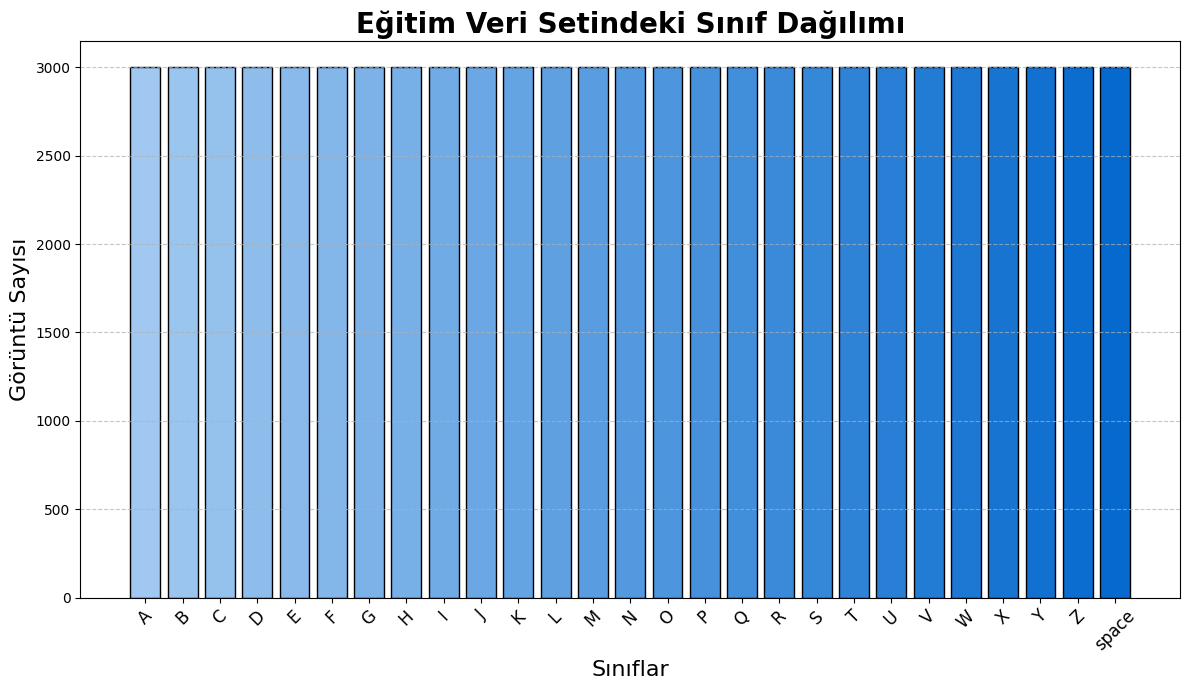

In [ ]:
# Her bir klasördeki görüntü sayısını sayma
image_counts = [len(os.listdir(os.path.join(path, folder))) for folder in files]

# Görselleştirme için matplotlib renk haritası oluşturma
from matplotlib.colors import LinearSegmentedColormap

# Grafik boyutunun ayarlanması
plt.figure(figsize=(12, 7))

# Gradient renk haritası oluşturuluyor (beyazdan maviye)
cmap = LinearSegmentedColormap.from_list("skyblue_gradient", ["#a0c8f0", "#0066cc"])

# Bar grafiği çizilir
bars = plt.bar(files, image_counts, color='skyblue', edgecolor='black')

# Çubuklara gradient renk uygulanması
for i, bar in enumerate(bars):
    bar.set_facecolor(cmap(i / len(bars)))

# Başlık ve etiketlerin eklenmesi
plt.title('Eğitim Veri Setindeki Sınıf Dağılımı', fontsize=20, fontweight='bold')
plt.xlabel('Sınıflar', fontsize=16)
plt.ylabel('Görüntü Sayısı', fontsize=16)

# X eksenindeki etiketlerin döndürülmesi
plt.xticks(rotation=45, fontsize=12)

# Y ekseninde izgaraların eklenmesi
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Grafik yerleşimi
plt.tight_layout()

# Grafiği ekrana yazdırma
plt.show()

# **Görüntülerin Yüklenmesi ve Etiketlenmesi**

In [ ]:
# Görüntüleri ve etiketlerini listelere eklemek için boş diziler oluşturuluyor
image_array = []
label_array = []

# Dosyalar arasında döngü başlatılıyor
for i in tqdm(range(len(files))):
    # Her klasördeki görüntülerin listelenmesi
    sub_file = os.listdir(path + "/" + files[i])

    # Her bir görüntü dosyasının üzerinde döngü
    for j in range(len(sub_file)):
        # Görüntü dosyasının yolu
        file_path = path + "/" + files[i] + "/" + sub_file[j]

        # Görüntüyü okuma
        image = cv2.imread(file_path)

        # Görüntüyü 96x96 boyutlarına yeniden boyutlandırma
        image = cv2.resize(image, (96, 96))

        # Görüntüyü BGR'den RGB'ye dönüştürme
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Görüntüyü dizilere ekleme
        image_array.append(image)

        # Etiket dizisine sınıf etiketini ekleme
        label_array.append(i)

100%|██████████| 27/27 [00:32<00:00,  1.20s/it]


# **Verilerin NumPy Dizilerine Dönüştürülmesi**

In [ ]:
# Listeleri numpy dizilerine dönüştürme
image_array = np.array(image_array)
label_array = np.array(label_array, dtype="float")

# **Eğitim ve Test Verisine Bölme**

In [ ]:
# sklearn kütüphanesinden train_test_split fonksiyonu ile veriyi eğitim ve test olarak ayırma
from sklearn.model_selection import train_test_split

# Veriyi %85 eğitim ve %15 test olacak şekilde ayırma
X_train, X_test, Y_train, Y_test = train_test_split(image_array, label_array, test_size=0.15)

# **Bellek Temizleme**

In [ ]:
# Bellek temizliği: Gereksiz veriler silinir
del image_array, label_array

# Çöp toplayıcıyı çalıştırma
import gc
gc.collect()

0

# **Modelin Oluşturulması**

In [ ]:
# Keras kütüphanesinden gerekli katmanlar ve modellerin import edilmesi
from keras import layers, callbacks, utils, applications, optimizers
from keras.models import Sequential, Model, load_model

# Modeli oluşturma
model = Sequential()

# model (EfficientNetB0) ekleniyor
pretrained_model = tf.keras.applications.EfficientNetB0(input_shape=(96, 96, 3), include_top=False)
model.add(pretrained_model)

# Global average pooling katmanı ekleniyor
model.add(layers.GlobalAveragePooling2D())

# Dropout katmanı ekleniyor (overfitting'i azaltmak için)
model.add(layers.Dropout(0.3))

# Çıktı katmanı ekleniyor
model.add(layers.Dense(1))

# Modelin yapısını belirleme
model.build(input_shape=(None, 96, 96, 3))

# Modelin özet bilgilerini yazdırma
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 3, 3, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)

# **Modeli Derleme**

In [ ]:
model.compile(optimizer="adam", loss="mae", metrics=["mae"])

# **En İyi Modeli Kaydetmek İçin Checkpoint Oluşturma**

In [ ]:
# Modelin en iyi doğrulama hatasıyla kaydedilmesini sağlayan callback (geri çağırma) fonksiyonu
ckp_path = "/content/working/best_model.weights.h5"  # En iyi modelin kaydedileceği dosya yolu
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=ckp_path,  # Modelin kaydedileceği dosyanın yolu
    monitor="val_mae",  # Doğrulama setindeki hata (val_mae) izlenir
    mode="auto",  # İyileşme yönü otomatik olarak seçilir (en düşük hata)
    save_best_only=True,  # Sadece en iyi model kaydedilir
    save_weights_only=True  # Yalnızca ağırlıklar kaydedilir, modelin tamamı değil
)

# **Öğrenme Oranını Azaltma**

In [ ]:
# Öğrenme oranını iyileşme olmuyorsa düşüren callback fonksiyonu
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    factor=0.9,  # Öğrenme oranını her seferinde %10 azaltır
    monitor="val_mae",  # Doğrulama hata metriği izlenir
    mode="auto",  # İyileşmeye göre öğrenme oranı azaltılır
    cooldown=0,  # Azaltma işleminden sonra bekleme süresi
    patience=5,  # Eğer 5 epoch boyunca iyileşme olmazsa öğrenme oranı düşürülür
    verbose=1,  # Azalma işlemi yapıldığında kullanıcıya bilgi verir
    min_lr=1e-6  # Öğrenme oranının alt sınırı
)

# **Modeli Eğitme**

In [ ]:
# Modelin eğitilmesi
Epochs = 50  # Modelin eğitileceği toplam epoch sayısı
Batch_Size = 32  # Eğitim verilerinin her seferinde işlenecek miktarı (batch)

history = model.fit(
    X_train,  # Eğitim verisi
    Y_train,  # Eğitim etiketleri
    validation_data=(X_test, Y_test),  # Doğrulama verisi
    batch_size=Batch_Size,  # Batch boyutu
    epochs=Epochs,  # Epoch sayısı
    callbacks=[model_checkpoint, reduce_lr]  # Eğitim sırasında kullanılacak callback fonksiyonları
)

Epoch 1/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 156s 41ms/step - loss: 2.4767 - mae: 2.4767 - val_loss: 0.3942 - val_mae: 0.3942 - learning_rate: 0.0010
Epoch 2/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 0.6061 - mae: 0.6061 - val_loss: 0.5113 - val_mae: 0.5113 - learning_rate: 0.0010
Epoch 3/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 40s 18ms/step - loss: 0.5680 - mae: 0.5680 - val_loss: 0.3350 - val_mae: 0.3350 - learning_rate: 0.0010
Epoch 4/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - loss: 0.4371 - mae: 0.4371 - val_loss: 0.5753 - val_mae: 0.5753 - learning_rate: 0.0010
Epoch 5/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 40s 19ms/step - loss: 0.4334 - mae: 0.4334 - val_loss: 0.3163 - val_mae: 0.3163 - learning_rate: 0.0010
Epoch 6/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - loss: 0.3480 - mae: 0.3480 - val_loss: 0.1755 - val_mae: 0.1755 - learning_rate: 0.0010
Epoch 7/50
2152/2152 ━━━━━━━━━━━━━━━━━━━━ 39s 18ms/step - loss: 0.3502 - mae: 0.3502 - val_loss: 0.2201 - val_mae: 0.2201 -

# **Eğitim ve Doğrulama Kaybı (Loss) ve Hata (MAE) Grafiklerini Çizme**

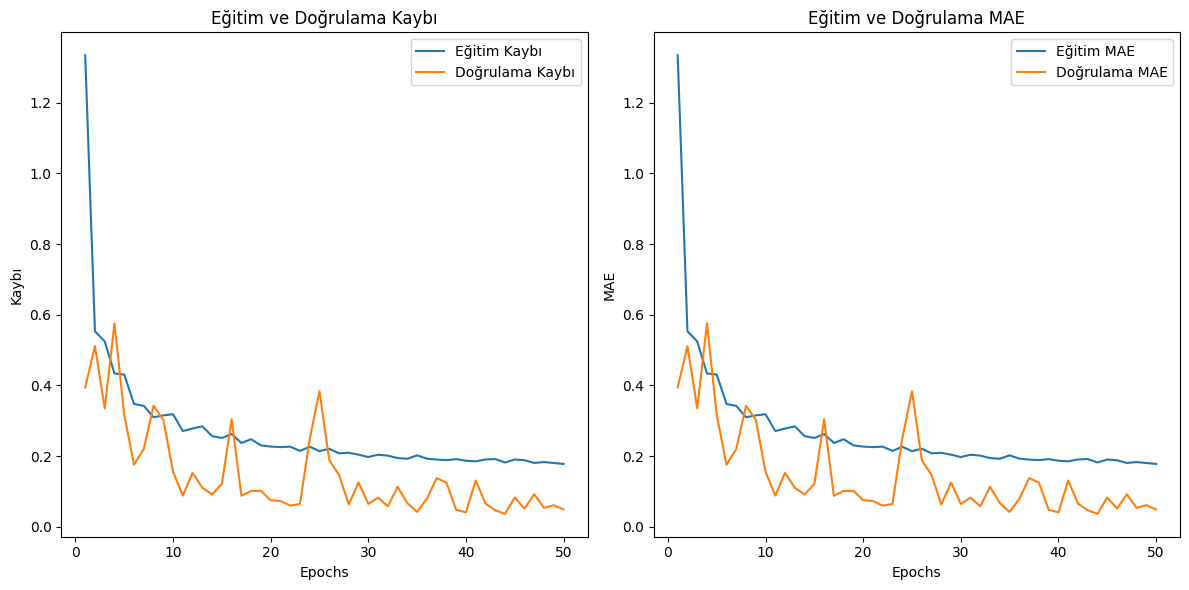

In [ ]:
# Eğitim ve doğrulama kayıplarını ve hata (MAE) grafiklerini çizme
history_dict = history.history  # Eğitim ve doğrulama metrikleri
epochs = range(1, Epochs + 1)  # Epoch sayıları

plt.figure(figsize=(12, 6))

# Eğitim ve doğrulama kaybı grafiği
plt.subplot(1, 2, 1)  # Grafik yerleşimi: 1 satır, 2 sütun, 1. grafik
plt.plot(epochs, history_dict['loss'], label='Eğitim Kaybı')  # Eğitim kaybı çizgisi
plt.plot(epochs, history_dict['val_loss'], label='Doğrulama Kaybı')  # Doğrulama kaybı çizgisi
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epochs')  # X ekseni: epoch sayısı
plt.ylabel('Kaybı')  # Y ekseni: kayıp
plt.legend()

# Eğitim ve doğrulama MAE grafiği
plt.subplot(1, 2, 2)  # Grafik yerleşimi: 1 satır, 2 sütun, 2. grafik
plt.plot(epochs, history_dict['mae'], label='Eğitim MAE')  # Eğitim MAE çizgisi
plt.plot(epochs, history_dict['val_mae'], label='Doğrulama MAE')  # Doğrulama MAE çizgisi
plt.title('Eğitim ve Doğrulama MAE')
plt.xlabel('Epochs')  # X ekseni: epoch sayısı
plt.ylabel('MAE')  # Y ekseni: MAE
plt.legend()

plt.tight_layout()  # Grafiklerin sıkı bir şekilde düzenlenmesini sağlar
plt.show()

# **Karışıklık Matrisi ile Model Performansını Görselleştirme**

380/380 ━━━━━━━━━━━━━━━━━━━━ 13s 19ms/step


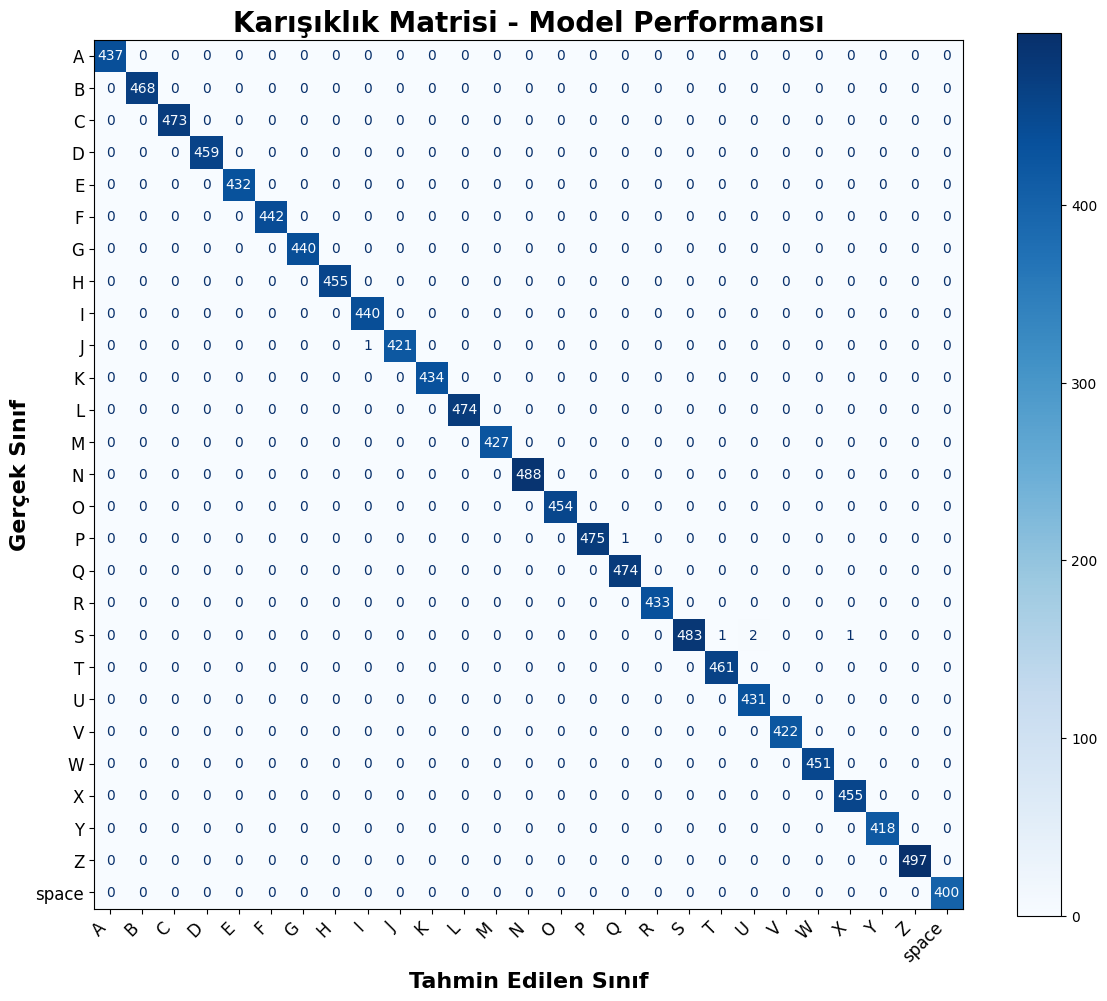

In [ ]:
# Karışıklık matrisi görselleştirme
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(X_test)  # Modelin tahminleri
y_pred_class = np.round(y_pred).astype(int)  # Tahmin edilen değerlerin yuvarlanarak sınıf türüne dönüştürülmesi

cm = confusion_matrix(Y_test, y_pred_class)  # Karışıklık matrisi hesaplanır

# Seaborn ile karışıklık matrisini görselleştirme
plt.figure(figsize=(12, 10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=files)  # Etiketler ve matrisi görüntüle
disp.plot(cmap='Blues', values_format='d', ax=plt.gca())  # Görselleştirme ayarları
plt.title("Karışıklık Matrisi - Model Performansı", fontsize=20, fontweight='bold', family='Arial')  # Başlık
plt.xlabel('Tahmin Edilen Sınıf', fontsize=16, fontweight='bold', family='Arial')  # X ekseni etiketi
plt.ylabel('Gerçek Sınıf', fontsize=16, fontweight='bold', family='Arial')  # Y ekseni etiketi
plt.xticks(rotation=45, fontsize=12, ha='right')  # X ekseni etiketlerinin açıları
plt.yticks(fontsize=12)  # Y ekseni etiketlerinin boyutu
plt.grid(False)  # Izgarayı kaldır
plt.tight_layout()  # Düzenin sıkıştırılması
plt.show()  # Grafik görüntülenmesi

# **Karşılık Gelen Alfabetik Harfe Çevirme**

In [ ]:
# Bu fonksiyon, modelin tahmin ettiği sayısal değeri alır ve ona karşılık gelen
# alfabetik harfi (A-Z arası veya boşluk) döndürür.
def get_alphabet_from_value(value):
    if value >= 0 and value < 0.5:
        return "A"
    elif value >= 0.5 and value < 1.5:
        return "B"
    elif value >= 1.5 and value < 2.5:
        return "C"
    elif value >= 2.5 and value < 3.5:
        return "D"
    elif value >= 3.5 and value < 4.5:
        return "E"
    elif value >= 4.5 and value < 5.5:
        return "F"
    elif value >= 5.5 and value < 6.5:
        return "G"
    elif value >= 6.5 and value < 7.5:
        return "H"
    elif value >= 7.5 and value < 8.5:
        return "I"
    elif value >= 8.5 and value < 9.5:
        return "J"
    elif value >= 9.5 and value < 10.5:
        return "K"
    elif value >= 10.5 and value < 11.5:
        return "L"
    elif value >= 11.5 and value < 12.5:
        return "M"
    elif value >= 12.5 and value < 13.5:
        return "N"
    elif value >= 13.5 and value < 14.5:
        return "O"
    elif value >= 14.5 and value < 15.5:
        return "P"
    elif value >= 15.5 and value < 16.5:
        return "Q"
    elif value >= 16.5 and value < 17.5:
        return "R"
    elif value >= 17.5 and value < 18.5:
        return "S"
    elif value >= 18.5 and value < 19.5:
        return "T"
    elif value >= 19.5 and value < 20.5:
        return "U"
    elif value >= 20.5 and value < 21.5:
        return "V"
    elif value >= 21.5 and value < 22.5:
        return "W"
    elif value >= 22.5 and value < 23.5:
        return "X"
    elif value >= 23.5 and value < 24.5:
        return "Y"
    elif value >= 24.5 and value < 25.5:
        return "Z"
    elif value >= 25.5 and value < 26.5:
        return "space"
    else:
        return ""

# **Model Tahmini ve Gerçek Değerlerle Karşılaştırma**

In [ ]:
# Modelin test verisi üzerinde tahmin yapması
prediction_val = model.predict(X_test, batch_size=32)

# İlk 30 tahmin ve gerçek etiketler için harfleri eşleştirerek liste oluşturuyoruz
data = []
for i, (pred_val, true_val) in enumerate(zip(prediction_val[:30], Y_test[:30])):
    predicted_value = pred_val[0]  # Tahmin edilen değerin ilk öğesi
    true_value = true_val  # Gerçek değer
    predicted_letter = get_alphabet_from_value(predicted_value)  # Tahmin edilen harf
    true_letter = get_alphabet_from_value(true_value)  # Gerçek harf
    data.append([i + 1, predicted_value, predicted_letter, true_value, true_letter])

# Sonuçları DataFrame'e dönüştürme
df = pd.DataFrame(data, columns=["Index", "Tahmin Değeri", "Tahmin Harfi", "Gerçek Değer", "Gerçek Harf"])

# Boşluklar ve görünüm için pandas ayarlarını düzenleme
pd.options.display.colheader_justify = 'center'  # Başlık hizalaması
pd.options.display.width = 100  # Satır genişliği

# Tabloyu yazdırma
print("\n" + "=" * 70)  # Netlik için üst çizgi
print("Tahminler ve Gerçek Etiketler Tablosu:".center(70))
print("=" * 70)
print(df.to_string(index=False, justify="center"))
print("=" * 70)  # Netlik için alt çizgi

380/380 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

                Tahminler ve Gerçek Etiketler Tablosu:                
 Index  Tahmin Değeri Tahmin Harfi  Gerçek Değer Gerçek Harf
   1      1.921892         C             2.0          C     
   2     18.006266         S            18.0          S     
   3      1.924513         C             2.0          C     
   4     23.046745         X            23.0          X     
   5      7.003100         H             7.0          H     
   6      5.945539         G             6.0          G     
   7      0.921365         B             1.0          B     
   8     17.104183         R            17.0          R     
   9     14.040814         O            14.0          O     
  10     16.015493         Q            16.0          Q     
  11      5.956519         G             6.0          G     
  12     13.053645         N            13.0          N     
  13     20.140272         U            20.0          U     
  14     15.070471         P     

# **Modelin En İyi Ağırlıklarını Yükleme**

In [ ]:
model.load_weights(ckp_path)

# **Modeli TensorFlow Lite Formatına Dönüştürme**

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # Keras modelini TFLite formatına dönüştürme
tflite_model = converter.convert()  # Modeli dönüştürme

# Dönüştürülen modeli kaydetme
with open("sign_lan.tflite", "wb") as f:
  f.write(tflite_model)  # Dönüştürülen modeli dosyaya yazma

Saved artifact at '/tmp/tmp8f5lx5z9'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 96, 96, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  135835954938272: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135835953948880: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  135842012675792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135839426529584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135839426583488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135839426591408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135839426529232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135839426536976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135839426534864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135839426538032: TensorSpec(shape=(), dtype=tf.resource, name=No